# 🔹 Пункт 1: сегментация на звуки → визуализация → датасет → train/val/test


пусть у нас есть длинный(на 32 минуты аудио файл audio.wav и mata.csv, которая коговорит, в каких отрезках времени какой класс)


1. загрузка необходимых библиотек + загрузка и первоначальный анализ аудиофайла

In [108]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit

AUDIO_PATH = "audio.wav"

y, sr = librosa.load(AUDIO_PATH, sr=None, mono=True)
duration = len(y) / sr

print("sr:", sr, "Гц") #частота дискретизации
print("длительность:", round(duration, 2), "сек") 
print("сэмплы:", len(y)) #кол-во сэмплов


sr: 44100 Гц
длительность: 1922.34 сек
сэмплы: 84775121


2. построим график амплитуды звука

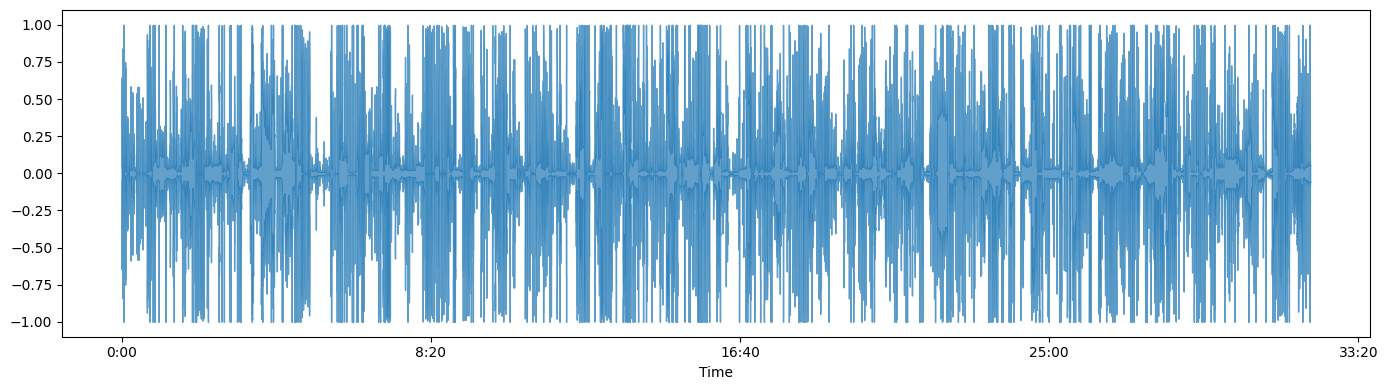

In [109]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.tight_layout()
plt.show()


3. Подготовка сигнала к автоматической сегментации на звуки


При анализе аудио librosa разбивает сигнал на короткие окна (фреймы) и сдвигает окно по времени с шагом hop_length (в сэмплах).

Если sr = 44100 и hop_length = 512, то один шаг по времени равен 
512/44100≈0.0116 секунды — примерно 11.6 миллисекунд.
​
То есть onset‑энергия o_env — это последовательность значений через каждые ~11.6 мс. Чем меньше hop_length, тем точнее по времени, но тем больше точек и нагрузка на вычисления.
​

 - Как примерно выбирать hop_length
Для общего аудио/музыки/звуков часто используют 256, 512 или 1024.
Если  события длятся десятки–сотни миллисекунд, шаг в районе 10–20 мс (то есть hop_length ≈ sr/100 – sr/50) даёт нормальное разрешение.



In [110]:
hop_length = 512

o_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length) #возвращает одномерный массив o_env, где каждый элемент соответствует кадру и показывает силу появления события 

onset_frames = librosa.onset.onset_detect(
    onset_envelope=o_env,
    sr=sr,
    hop_length=hop_length,
    backtrack=True,
    units="frames"
)
# находит конкретные кадры onset_frames, где происходят onsets (начала звуков). Параметр backtrack=True сдвигает найденный onset назад к ближайшему минимуму энергии, что даёт более аккуратные точки разреза для сегментации

onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length) #переводим кадры в секунды

print("n_onsets:", len(onset_frames))


n_onsets: 2442


4. Нарисуем график сигнала по времени + на нем красными пунктирами обочзначим размеченные отрезки(границы сегментов)

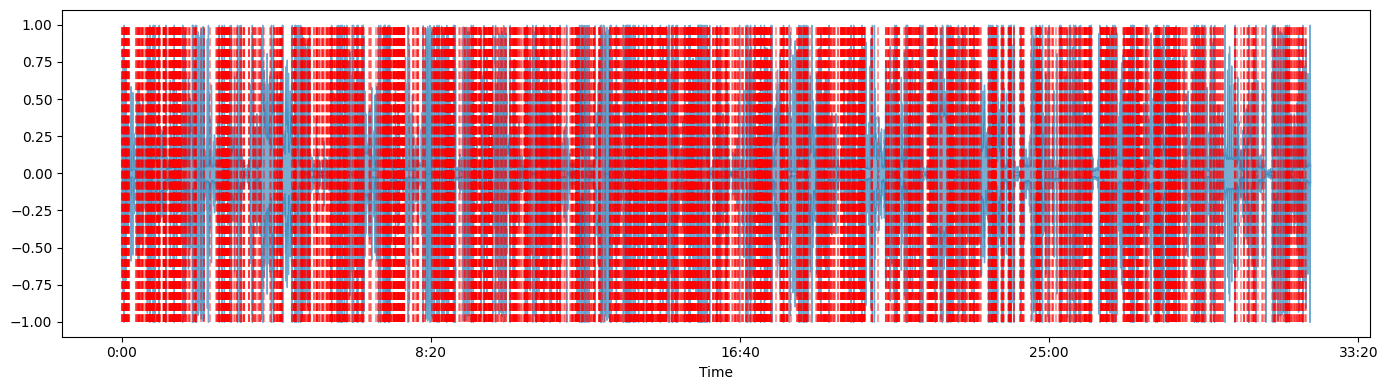

In [111]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(onset_times, ymin=y.min(), ymax=y.max(), color="r", alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


5. режем наше аудио на отдельные куски и складываем информацию о них в таблицу

In [112]:
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)
cut_points = np.unique(np.concatenate([[0], onset_samples, [len(y)]]))

min_dur = 0.2  # минимум длительности сегмента, сек

segments = []
for i in range(len(cut_points) - 1):
    start = int(cut_points[i])
    end = int(cut_points[i + 1])
    seg_y = y[start:end]
    dur = (end - start) / sr
    if dur >= min_dur:
        segments.append({
            "segment_id": len(segments),
            "start_sample": start,
            "end_sample": end,
            "start_time": start / sr,
            "end_time": end / sr,
            "duration": dur,
            "y": seg_y,
            "label": "unknown"   # пока не знаем класс
        })

df_segments = pd.DataFrame(segments)
df_segments.head()


,segment_id,start_sample,end_sample,start_time,end_time,duration,y,label
0,0,3584,50176,0.081270,1.137778,1.056508,"[0.0052490234, 0.005218506, 0.00491333, 0.0045...",unknown
1,1,50176,66560,1.137778,1.509297,0.371519,"[0.056243896, 0.059570312, 0.06210327, 0.06295...",unknown
2,2,66560,88064,1.509297,1.996916,0.487619,"[0.0006713867, 0.0011901855, 0.0015258789, 0.0...",unknown
3,3,88064,134144,1.996916,3.041814,1.044898,"[-0.001159668, -0.0014038086, -0.0014038086, -...",unknown
4,4,134144,174592,3.041814,3.959002,0.917188,"[0.0010681152, 0.0009765625, 0.0007019043, 0.0...",unknown


посмотрим на длительности полученных сегментов 

In [113]:
df_segments["duration"].describe()


count    1556.000000
mean        1.173946
std         1.646756
min         0.208980
25%         0.371519
50%         0.650159
75%         1.265488
max        17.995465
Name: duration, dtype: float64

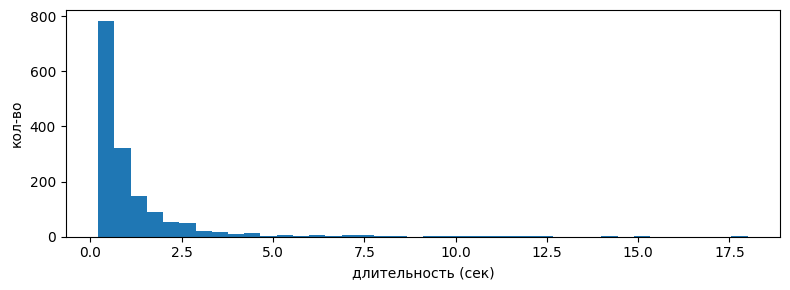

In [114]:
plt.figure(figsize=(8, 3))
plt.hist(df_segments["duration"], bins=40)
plt.xlabel("длительность (сек)")
plt.ylabel("кол-во")
plt.tight_layout()
plt.show()


5. почистим сегменты тишины (которые в дальнешем будут только мешать обучению)

In [115]:
# считаем среднюю энергию (RMS) для каждого сегмента
rms_means = []
for seg in df_segments["y"]:
    rms = librosa.feature.rms(y=seg).mean()
    rms_means.append(rms)

df_segments["rms_mean"] = rms_means

# смотрим распределение RMS, чтобы понять, какой порог тишины выбрать
print(df_segments["rms_mean"].describe())

# пусть нижние 10% по громкости — это тишина
silence_thr = df_segments["rms_mean"].quantile(0.10)

# оставляем только сегменты, которые громче тишины
df_segments = df_segments[df_segments["rms_mean"] > silence_thr].reset_index(drop=True)

print("Сегментов после удаления тишины:", len(df_segments))


count    1556.000000
mean        0.070082
std         0.065652
min         0.000154
25%         0.021117
50%         0.049714
75%         0.103000
max         0.529354
Name: rms_mean, dtype: float64
Сегментов после удаления тишины: 1400


6. посмотрим файл meta, который хранит информацию про классы

In [116]:
meta_df = pd.read_csv("meta_df.csv")
meta_df.head()


,label,start_time,end_time
0,dog,0.000000,11.900000
1,cat,11.900000,23.900000
2,dog,23.900000,35.200000
3,dog,35.200000,50.329637
4,dog,50.329637,53.161020


7. напишем функцию, которая присваивает каждому аудио-сгементу метку класса, глядя на врменные интервалы 

In [117]:
def assign_label(seg_row, meta_df):
    mid = (seg_row["start_time"] + seg_row["end_time"]) / 2.0
    hits = meta_df[(meta_df["start_time"] <= mid) & (meta_df["end_time"] >= mid)]
    return hits.iloc[0]["label"]


8. дополним метками класса все наши сегменты

In [118]:
df_segments["label"] = df_segments.apply(lambda r: assign_label(r, meta_df), axis=1)
df_segments["label"].value_counts()
df_segments.head()


,segment_id,start_sample,end_sample,start_time,end_time,duration,y,label,rms_mean
0,0,3584,50176,0.081270,1.137778,1.056508,"[0.0052490234, 0.005218506, 0.00491333, 0.0045...",dog,0.042982
1,1,50176,66560,1.137778,1.509297,0.371519,"[0.056243896, 0.059570312, 0.06210327, 0.06295...",dog,0.056899
2,2,66560,88064,1.509297,1.996916,0.487619,"[0.0006713867, 0.0011901855, 0.0015258789, 0.0...",dog,0.112912
3,3,88064,134144,1.996916,3.041814,1.044898,"[-0.001159668, -0.0014038086, -0.0014038086, -...",dog,0.011975
4,4,134144,174592,3.041814,3.959002,0.917188,"[0.0010681152, 0.0009765625, 0.0007019043, 0.0...",dog,0.059160


In [119]:
dataset_df = df_segments.drop(columns=["y"]).copy()
dataset_df.head()


,segment_id,start_sample,end_sample,start_time,end_time,duration,label,rms_mean
0,0,3584,50176,0.081270,1.137778,1.056508,dog,0.042982
1,1,50176,66560,1.137778,1.509297,0.371519,dog,0.056899
2,2,66560,88064,1.509297,1.996916,0.487619,dog,0.112912
3,3,88064,134144,1.996916,3.041814,1.044898,dog,0.011975
4,4,134144,174592,3.041814,3.959002,0.917188,dog,0.059160


9. отфильструем датасэт удалив метки, где нет метки

In [120]:
dataset_labeled = dataset_df[dataset_df["label"].isin(["cat", "dog"])].reset_index(drop=True)
print("Всего размеченных сегментов:", len(dataset_labeled))
print(dataset_labeled["label"].value_counts())


Всего размеченных сегментов: 1400
label
cat    814
dog    586
Name: count, dtype: int64


10. делим на обучающую и тестовые выборки 80/20

In [121]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(
    dataset_labeled,
    test_size=0.2,          
    random_state=42,
    stratify=dataset_labeled["label"]
)

print("Train+Val:", len(train_val_df), "Test:", len(test_df))
print("Test labels:\n", test_df["label"].value_counts())


Train+Val: 1120 Test: 280
Test labels:
 label
cat    163
dog    117
Name: count, dtype: int64


11. при необходимости можем поедлить на train и val

In [122]:
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,        
    random_state=42,
    stratify=train_val_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 896 Val: 224 Test: 280


 🔹 момент: может быть что в записи будут строго известны моменты через коротые резать, допустим паузы по 1 сек, в таком случае можно разбитть аудиофайл таким образом

In [ ]:
import librosa
import soundfile as sf
import numpy as np
from pathlib import Path

audio_path = "long_audio.wav"
out_dir = Path("segments")
out_dir.mkdir(exist_ok=True)

y, sr = librosa.load(audio_path, sr=None, mono=True)

silence_threshold = 1e-3 # порог тишины
one_sec = sr # ровно 1 секунда в сэмплах

is_silent = np.abs(y) < silence_threshold

segments = []
current_start = 0
silent_run = 0

for i, silent in enumerate(is_silent):
    if silent:
        silent_run += 1
    else:
        # только что закончилась тишина
        if silent_run > 0:
            if silent_run == one_sec:
                # РОВНО 1 сек тишины -> режем
                cut_pos = i - silent_run
                if cut_pos > current_start:
                    segments.append((current_start, cut_pos))
                    current_start = i  # новый звук после паузы
            # если тишина != 1 сек, считаем её частью звука и не режем
        silent_run = 0

if current_start < len(y):
    segments.append((current_start, len(y)))

for idx, (s, e) in enumerate(segments):
    seg = y[s:e]
    if len(seg) == 0:
        continue
    out_path = out_dir / f"segment_{idx:03d}.wav"
    sf.write(out_path, seg, sr)



 🔹 момент2 : просто порезать аудио по 1 сек

In [ ]:
import librosa
import soundfile as sf
from pathlib import Path

audio_path = "long_audio.wav"
out_dir = Path("chunks_1s")
out_dir.mkdir(exist_ok=True)

# читаем аудио
y, sr = librosa.load(audio_path, sr=None, mono=True)

chunk_sec = 1.0
chunk_len = int(chunk_sec * sr)  # 1 секунда в сэмплах

# режем по 1 секунде
for i, start in enumerate(range(0, len(y), chunk_len)):
    end = start + chunk_len
    chunk = y[start:end]
    if len(chunk) == 0:
        continue
    out_path = out_dir / f"chunk_{i:04d}.wav"
    sf.write(out_path, chunk, sr)


# 🔹 Пункт 2: Представление аудио в цифровом формате

In [124]:
import os
import librosa
import numpy as np

DATA_DIR = "cats_dogs"
SR = 16000  # одна частота дискретизации для всего датасета

1. сырой сигнал (waveform) каждый файл превращается в вектор амплитуд y с собственной длиной

Такое представление удобно для моделей на торч-аудио или простых базовых экспериментов. librosa.load возвращает одномерный NumPy‑массив амплитуд и частоту дискретизации

- Подойдёт для PyTorch‑моделей (1D‑CNN, RNN), где паддинг делается уже в DataLoader
Дальше можно писать PyTorch‑датасет, который в __getitem__ возвращает один массив, а в collate_fn паддить батч до общей длины.

In [137]:
def load_wave(path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    return y.astype(np.float32)

def load_split(split):
    X, y = [], []
    for name, label in [("cat", 0), ("dog", 1)]:
        folder = os.path.join(DATA_DIR, split, name)
        for fname in os.listdir(folder):
            if fname.lower().endswith(".wav"):
                X.append(load_wave(os.path.join(folder, fname)))
                y.append(label)
    return X, np.array(y, dtype=np.int64)

X_train_wave, y_train_wave = load_split("train")
X_test_wave,  y_test_wave  = load_split("test")

print(len(X_train_wave), len(X_test_wave))


210 67


2. Мел‑спектрограммы (матрицы частота×время)
Мел‑спектрограмма — это способ превратить звук в картинку, где по вертикали частоты (в мел‑шкале), по горизонтали время, а в ячейках яркость = энергия. Такое представление очень удобно для 2D‑CNN

Звук режут на короткие окна (обычно 20–40 мс) и для каждого окна считают спектр (STFT).​

Затем спектр пропускают через банк мел‑фильтров и суммируют энергию в нескольких диапазонах, например 64 или 128 полос

In [ ]:
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256

def to_melspec(y):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )              
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def load_split_mels(split):
    X, y = [], []
    for name, label in [("cat", 0), ("dog", 1)]:
        folder = os.path.join(DATA_DIR, split, name)
        for fname in os.listdir(folder):
            if fname.lower().endswith(".wav"):
                path = os.path.join(folder, fname)
                y_wave, _ = librosa.load(path, sr=SR, mono=True)
                X.append(to_melspec(y_wave))
                y.append(label)
    return X, np.array(y, dtype=np.int64)

X_train_spec, y_train_spec = load_split_mels("train")
X_test_spec,  y_test_spec  = load_split_mels("test")

print(len(X_train_spec),len(X_test_spec))
# Здесь X_train_spec — список матриц разных длин по времени T_i; высота N_MELS фиксирована


210 67


3. MFCC‑признаки 
Здесь получается чистый табличный датасет фиксированного размера, что идеально для SVM, RandomForest, LogisticRegression, MLP

In [ ]:
N_MFCC = 20

def file_to_mfcc(path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC)  
    mfcc_mean = mfcc.mean(axis=1)                          
    return mfcc_mean.astype(np.float32)

def load_split_mfcc(split):
    X, y = [], []
    for name, label in [("cat", 0), ("dog", 1)]:
        folder = os.path.join(DATA_DIR, split, name)
        for fname in os.listdir(folder):
            if fname.lower().endswith(".wav"):
                path = os.path.join(folder, fname)
                X.append(file_to_mfcc(path)) 
                y.append(label)
    return np.stack(X), np.array(y, dtype=np.int64)

X_train_mfcc, y_train_mfcc = load_split_mfcc("train")
X_test_mfcc,  y_test_mfcc  = load_split_mfcc("test")

Train MFCC shape: (210, 20)
Test  MFCC shape: (67, 20)


обучим сразу модель LG для примера

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

clf.fit(X_train_mfcc, y_train_mfcc)
print("accuracy:", clf.score(X_test_mfcc, y_test_mfcc))


Test accuracy: 0.8805970149253731


# 3. Корреляционный анализ классов
разберем на примереданных которые мы получили при MFCC

посчитаем коэффициенты корреляции пирсона между всеми парами MFCC признаков
Это показывает, какие признаки ведут себя похоже и могут быть избыточными

In [150]:
import pandas as pd

# преобразуем в DataFrame для удобства
mfcc_cols = [f"mfcc_{i+1}" for i in range(X_train_mfcc.shape[1])]
df_mfcc = pd.DataFrame(X_train_mfcc, columns=mfcc_cols)

corr_matrix = df_mfcc.corr(method="pearson")
corr_matrix


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
mfcc_1,1.000000,-0.114357,-0.286112,0.028774,-0.206942,-0.115836,-0.025059,-0.022806,-0.025000,-0.015676,-0.063383,0.011858,-0.201692,-0.113892,-0.010591,-0.019578,0.006191,0.024739,-0.068256,-0.107373
mfcc_2,-0.114357,1.000000,-0.100501,-0.459219,-0.128541,-0.404129,-0.052103,-0.542324,-0.164585,0.098642,0.086335,-0.477279,0.317740,0.162053,-0.423959,-0.308608,-0.389265,-0.369720,0.265724,-0.014356
mfcc_3,-0.286112,-0.100501,1.000000,0.525323,0.536964,0.703161,0.370224,0.454051,0.032928,0.048367,0.116774,0.274968,-0.071868,0.150492,0.320848,0.375075,0.273968,0.182599,-0.204174,-0.052049
mfcc_4,0.028774,-0.459219,0.525323,1.000000,0.526758,0.656715,0.465615,0.616697,0.222192,0.115922,0.010372,0.600162,-0.311762,-0.052866,0.479625,0.395150,0.491351,0.467198,-0.308588,0.056261
mfcc_5,-0.206942,-0.128541,0.536964,0.526758,1.000000,0.620899,0.592904,0.541014,0.282723,0.189694,0.042886,0.352341,0.062215,0.167937,0.373527,0.345019,0.208009,0.266392,-0.053092,0.127103
mfcc_6,-0.115836,-0.404129,0.703161,0.656715,0.620899,1.000000,0.491427,0.719155,0.166048,0.092436,0.156501,0.421892,-0.097519,0.271594,0.475063,0.500935,0.419914,0.308209,-0.243343,-0.066254
mfcc_7,-0.025059,-0.052103,0.370224,0.465615,0.592904,0.491427,1.000000,0.447415,0.350007,0.356309,0.160460,0.217303,0.186567,0.136972,0.262911,0.234879,0.194095,0.222649,0.094538,0.170972
mfcc_8,-0.022806,-0.542324,0.454051,0.616697,0.541014,0.719155,0.447415,1.000000,0.399398,0.235785,-0.006219,0.498152,-0.211253,0.064632,0.574958,0.509084,0.510957,0.450160,-0.186636,0.097553
mfcc_9,-0.025000,-0.164585,0.032928,0.222192,0.282723,0.166048,0.350007,0.399398,1.000000,0.542796,0.231444,0.135198,0.069565,-0.138059,0.078514,0.045889,0.219505,0.221425,0.299719,0.276174
mfcc_10,-0.015676,0.098642,0.048367,0.115922,0.189694,0.092436,0.356309,0.235785,0.542796,1.000000,0.442356,-0.010006,0.231215,-0.130411,-0.106606,-0.026274,0.171680,0.113879,0.416629,0.382700


сделаем heatmap

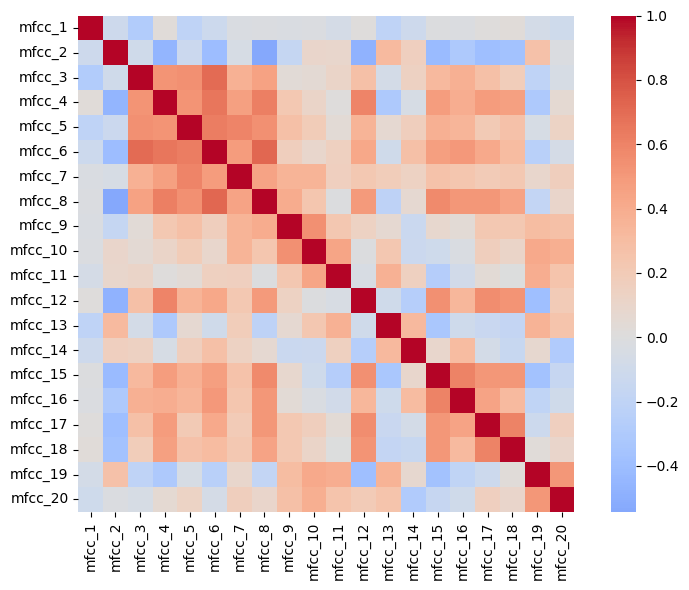

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True)
plt.tight_layout()
plt.show()


MFCC‑3–MFCC‑6 сильно коррелируют также 4-12, 6 - 8. В дальнейшем если дата большая слишком можно удалить один из коррелирующих признаков

# 🔹Гистограммы одного признака по двум классам
Построим гистограммы, например, для mfcc_1 и mfcc_2 одновременно для котов и собак. Смотрим, насколько сильно разъезжаются распределения; если почти не пересекаются, признак хорошо отличает классы

Если гистограммы почти лежат друг на друге (похожая форма и область значений), признак мало помогает отличать сигналы и даёт слабую информацию для классификации

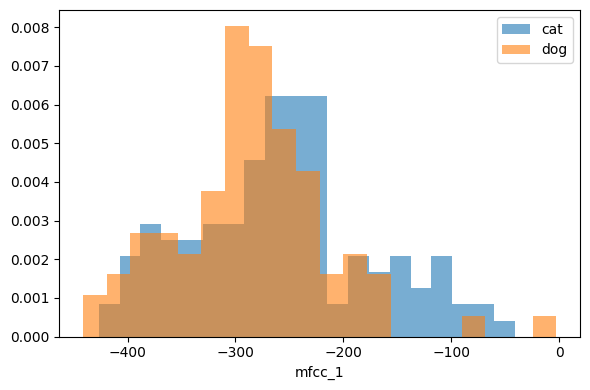

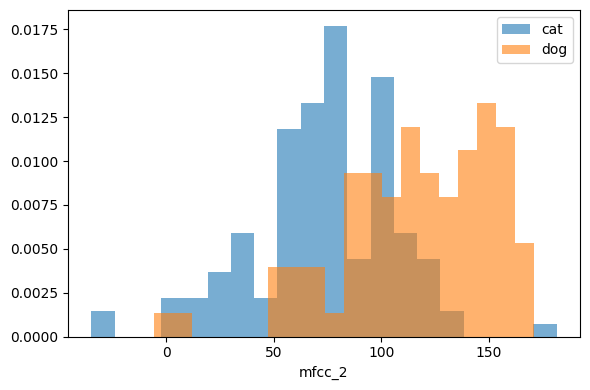

In [149]:
def plot_hist_for_feature(idx):
    name = mfcc_cols[idx]
    cats = X_train_mfcc[y_train_mfcc == 0, idx]
    dogs = X_train_mfcc[y_train_mfcc == 1, idx]

    plt.figure(figsize=(6, 4))
    plt.hist(cats, bins=20, alpha=0.6, label="cat", density=True)
    plt.hist(dogs, bins=20, alpha=0.6, label="dog", density=True)
    plt.xlabel(name)
    plt.legend()
    plt.tight_layout()
    plt.show()

# пример: первые два MFCC
plot_hist_for_feature(0)  # mfcc_1
plot_hist_for_feature(1)  # mfcc_2
